In [1]:
import math
import pypot.dynamixel
from pypot.dynamixel.conversion import dxl_code
from pypot.dynamixel.conversion import dxl_decode
from time import sleep, time

from lib import Motor
import control_tables
from utils import read_from_file, dxl_decode_value

import matplotlib
import matplotlib.pyplot as plt
from utils import write_in_file
import numpy as np

plt.style.use("ggplot")

## Setting up the motor

In [2]:
DXL_ID = 20
PORT = "/dev/ttyUSB1"
INPUT_TENSION = 12.78

configs = {
    "MX-106": {"resistance": 2.0, "torque_constant": 2.3593725498111775},
    "MX-64": {"resistance": 3.6, "torque_constant": 8.011176076962043},
}

In [3]:
dxl_io = pypot.dynamixel.Dxl320IO(PORT)
motor = Motor(dxl_io, DXL_ID, control_tables.MX_106, configs['MX-106']['resistance'], configs['MX-106']['torque_constant'], INPUT_TENSION)

motor.torque_enabled = False
motor.mode = 16 # PWM Control mode
motor.torque_enabled = True
motor.motor_tension = 0

## Benchmarking values

In [4]:
times = []
positions = []
motor_tension = []
motor_torques = []
velocities = []
back_emfs = []

for pwm_unit in range(-500, 500):
    motor.motor_tension = pwm_unit / 100

    sleep(.1)

    times.append(time())
    positions.append(motor.position)
    motor_tension.append(motor.motor_tension)
    motor_torques.append(motor.torque)
    velocities.append(motor.velocity)
    back_emfs.append(motor.back_emf)


write_in_file(times, "times.txt")
write_in_file(positions, "positions.txt")
write_in_file(motor_tension, "motor_tension.txt")
write_in_file(motor_torques, "motor_torques.txt")
write_in_file(velocities, "velocities.txt")
write_in_file(back_emfs, "back_emfs.txt")

motor.motor_tension = 0
motor.torque_enabled = False

Les values ont été écrites dans le fichier times.txt avec succès.
Les values ont été écrites dans le fichier positions.txt avec succès.
Les values ont été écrites dans le fichier motor_tension.txt avec succès.
Les values ont été écrites dans le fichier motor_torques.txt avec succès.
Les values ont été écrites dans le fichier velocities.txt avec succès.
Les values ont été écrites dans le fichier back_emfs.txt avec succès.


In [5]:
times = np.array(read_from_file("times.txt"))
positions = np.array(read_from_file("positions.txt"))
motor_tension = np.array(read_from_file("motor_tension.txt"))
motor_torques = np.array(read_from_file("motor_torques.txt"))
velocities = np.array(read_from_file("velocities.txt"))
back_emfs = np.array(read_from_file("back_emfs.txt"))

Static friction: 1.6924923335745818


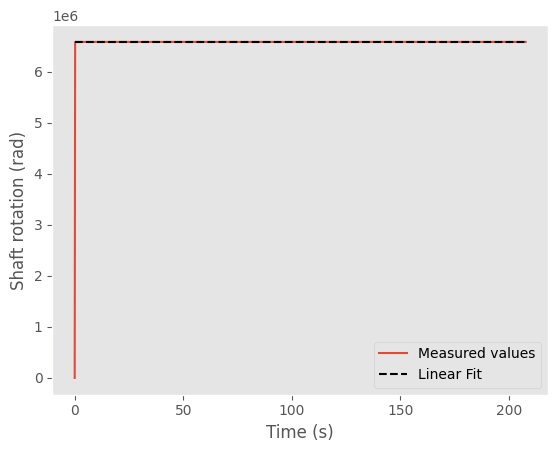

In [6]:
first_time = times[0]
times_scaled = np.array(list(map(lambda x: x - first_time, times)))
positions_rad = np.array(list(map(lambda x: math.radians(x), positions)))

plt.figure()
plt.grid()
plt.plot(times_scaled, positions_rad, label="Measured values")

# Resample
lower_bound = 180
index = -1
for i, value in enumerate(times_scaled):
    if value >= lower_bound:
        index = i
        break

# Remap times
slope, intersect = np.polyfit(times_scaled[index:], positions_rad[index:], 1)
poly1d_fn = np.poly1d((slope, intersect))

print(f"Static friction: {slope}")
plt.plot(times_scaled, poly1d_fn(times_scaled), '--k', label="Linear Fit")

plt.xlabel("Time (s)")
plt.ylabel("Shaft rotation (rad)")
plt.legend()

plt.show()

## Inertial moment of the attached bar

$$J_\Delta = \int_V r_\Delta^2 \mathrm{d}m$$
$r$ being the distance of each point of the solid from the $\Delta$ axis.

$$J_\Delta =\int_V \rho l e \mathrm{d}x = \rho le \left[ \frac{x^3}{3} \right]^L_0 = \rho le \frac{L^3}{3} = \frac{mL^2}{3}$$

In [7]:
mass = 0.08 # Kg
length = 0.5 # m
inertial_moment = (mass * pow(length, 2)) / 3

print(f"Inertial moment: {inertial_moment} Kg.m^2")

Inertial moment: 0.006666666666666667 Kg.m^2


# Friction models

In [8]:
from scipy.optimize import curve_fit

angular_velocities = list(map(lambda x: x * (np.pi / 30), velocities)) # To rad.s^{-1}

def plot_model(model, popt, name="Friction model"):
    # Generate points for plotting the fitted curve
    friction_torque_fit = [model(x, *popt) for x in angular_velocities]

    # Plot the data and the fitted curve
    plt.figure(figsize=(10, 6))
    plt.scatter(angular_velocities, motor_torques, label='Data Points')
    plt.plot(angular_velocities, friction_torque_fit, 'b-', label='Fitted Friction Model')
    plt.xlabel('Angular Velocity (rad/s)')
    plt.ylabel('Friction Torque (Nm)')
    plt.title(name)
    plt.legend()
    plt.grid(True)
    plt.show()

## Polynomial model

This polynomial model is a simple model using third degree polynomials to fit the curve:

$$
    f(x) = \begin{cases}
        ax^3 + bx^2 + cx + d,& \text{if } x < 0 \\
        ex^3 + fx^2 + gx + h,& \text{if } x > 0 \\
        0, & \text{otherwise}
    \end{cases}
$$

Coefficients: [-0.12362321 -0.57141852 -0.51591434 -0.27241677 -0.13292098  0.57942979
 -0.50890823  0.26834108]


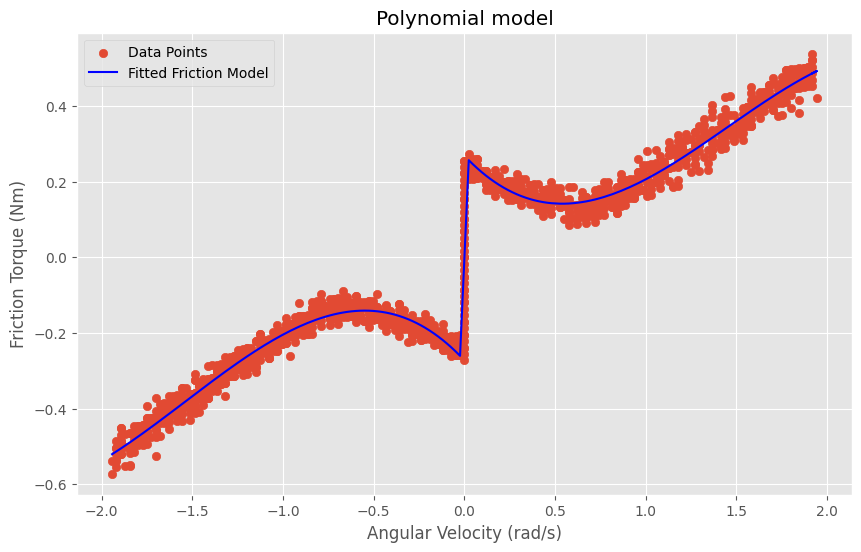

In [9]:
def polynomial_model(x, a, b, c, d, e, f, g, h):
    return np.where(x < 0, a * x ** 3 + b * x ** 2 + c * x + d, np.where(x > 0, e * x ** 3 + f * x ** 2 + g * x + h, 0))

popt, pcov = curve_fit(polynomial_model, angular_velocities, motor_torques)
print(f"Coefficients: {popt}")

plot_model(polynomial_model, popt, "Polynomial model")

As seen in the previous code cell, two polynomials of degree 3 are enough to approximate the measured values for the friction torque.

## Coulomb friction

The Coulomb model is defined by the following equation (from [Adaptive Identification and Control of Uncertain Systems with Non-smooth Dynamics, by Jing Na, Qiang Chen and Xuemei Ren, Chapter 1](https://www.sciencedirect.com/science/article/abs/pii/B9780128136836000039)):

$$
T_{f}=f_{c}\operatorname{sgn}({\dot{x}}) 
$$

Coulomb coeff: 0.2661769771815107


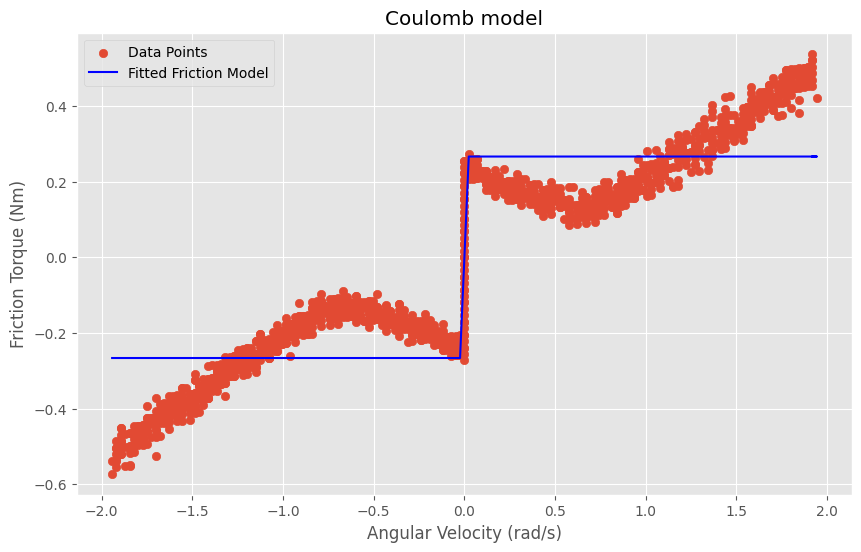

In [10]:
def coulomb_model(omega, coulomb_coeff):
    return coulomb_coeff * np.sign(omega)

popt, pcov = curve_fit(coulomb_model, angular_velocities, motor_torques)
coulomb_coeff = popt[0]
print(f"Coulomb coeff: {coulomb_coeff}")

plot_model(coulomb_model, popt, "Coulomb model")

As expected, the Coulomb model allows a extremely rough approximation of the friction torques that can be measured. However, the Coulomb friction model does not accurately capture the stick-slip phenomenon that is measured when the angular velocity is nearing 0.

## Stribeck model

The Stribeck model is defined by the following equation (from [Adaptive Identification and Control of Uncertain Systems with Non-smooth Dynamics, by Jing Na, Qiang Chen and Xuemei Ren, Chapter 1](https://www.sciencedirect.com/science/article/abs/pii/B9780128136836000039)):

$$
T_{f}=f_{c}\operatorname{sgn}({\dot{x}})+(f_{s}-f_{c})e^{-\left({\dot{x}}/{\dot{x}}_{s}\right)^{2}}+f_{v}{\dot{x}} 
$$

Stribeck model's parameters:
	Dynamic friction torque (F_c) = -0.0011290596938334557 N.m
	Static friction torque (F_s) = 0.22047280333906938 N.m
	Stribeck velocity (v_s) = 0.3338122103926749 rad.s^{-1}
	Viscous friction coefficient = 0.2392765860799163


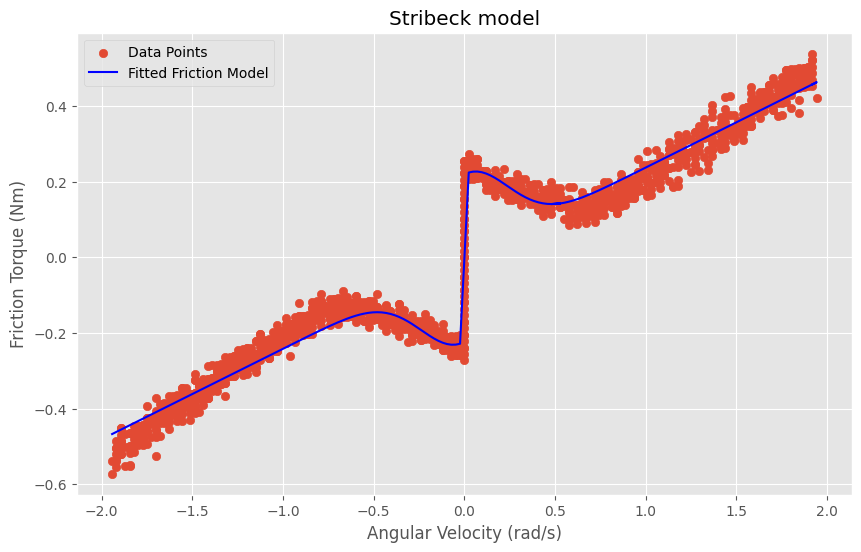

In [11]:
def stribeck_model(omega, dynamic_friction_torque, stiction_torque, stribeck_velocity, viscous_friction_coefficient):
    return (dynamic_friction_torque * np.sign(omega) + (stiction_torque - dynamic_friction_torque) * np.exp(-(omega / stribeck_velocity) ** 2)) * np.sign(omega) + dynamic_friction_torque + viscous_friction_coefficient * omega

popt, pcov = curve_fit(stribeck_model, angular_velocities, motor_torques)
dynamic_friction_torque, stiction_torque, stribeck_velocity, viscous_friction_coefficient = popt

print(f"Stribeck model's parameters:")
print(f"\tDynamic friction torque (F_c) = {dynamic_friction_torque} N.m")
print(f"\tStatic friction torque (F_s) = {stiction_torque} N.m")
print(f"\tStribeck velocity (v_s) = {stribeck_velocity} rad.s^{{-1}}")
print(f"\tViscous friction coefficient = {viscous_friction_coefficient}")

plot_model(stribeck_model, popt, "Stribeck model")

The Stribeck model (also called Coulomb-Stribeck) is one of the best friction models, describing the stick-slip phenomenon while not being too complicated. We can see that this model actually fits our data. 

## Lorentzian model

The Lorentzian model is defined by the following equation (from [Adaptive Identification and Control of Uncertain Systems with Non-smooth Dynamics, by Jing Na, Qiang Chen and Xuemei Ren, Chapter 1](https://www.sciencedirect.com/science/article/abs/pii/B9780128136836000039)):

$$
T_{f}=f_{c}\mathrm{sgn}({\dot{x}})+(f_{s}-f_{c})\frac{1}{1+({\dot{x}}/{\dot{x}_{s}})^{2}}+f_{v}{\dot{x}} 
$$

Stribeck model's parameters:
	Dynamic friction torque (F_c) = 0.08558111409527012 N.m
	Static friction torque (F_s) = 0.08327533227008492 N.m
	Stribeck velocity (v_s) = 379.65973413761435 rad.s^{-1}
	Viscous friction coefficient = 0.17824670994564337


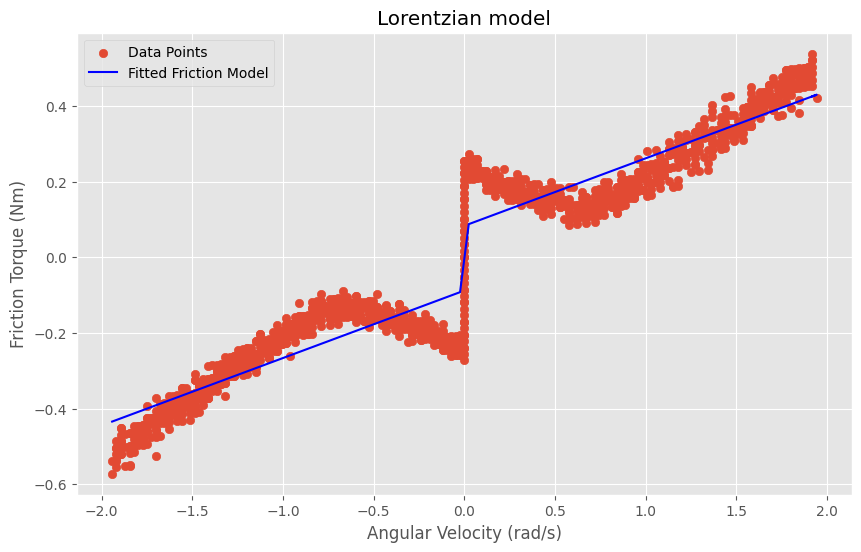

In [12]:
def lorentzian_model(omega, dynamic_friction_torque, stiction_torque, stribeck_velocity, viscous_friction_coefficient):
    return dynamic_friction_torque * np.sign(omega) + (stiction_torque - dynamic_friction_torque) * (1 / (1 + np.power((omega / stribeck_velocity), 2))) + viscous_friction_coefficient * omega

popt, pcov = curve_fit(lorentzian_model, angular_velocities, motor_torques)

print(f"Stribeck model's parameters:")
print(f"\tDynamic friction torque (F_c) = {popt[0]} N.m")
print(f"\tStatic friction torque (F_s) = {popt[1]} N.m")
print(f"\tStribeck velocity (v_s) = {popt[2]} rad.s^{{-1}}")
print(f"\tViscous friction coefficient = {popt[3]}")

plot_model(lorentzian_model, popt, "Lorentzian model")

This model is a simpler way of describing the Coulomb-Stribeck model, but we did not manage to make it work, as seen in the code cell above. 

## LuGre model

The LuGre model is defined by the following equation (from [Adaptive Identification and Control of Uncertain Systems with Non-smooth Dynamics, by Jing Na, Qiang Chen and Xuemei Ren, Chapter 1](https://www.sciencedirect.com/science/article/abs/pii/B9780128136836000039)):


$$
T_{f}=\sigma_{0}z+\sigma_{1}\dot{z}+\sigma_{2}\dot{z} 
$$

$$
z=\hat{x}-\frac{|\hat{x}|}{g(\hat{x})}\,z 
$$


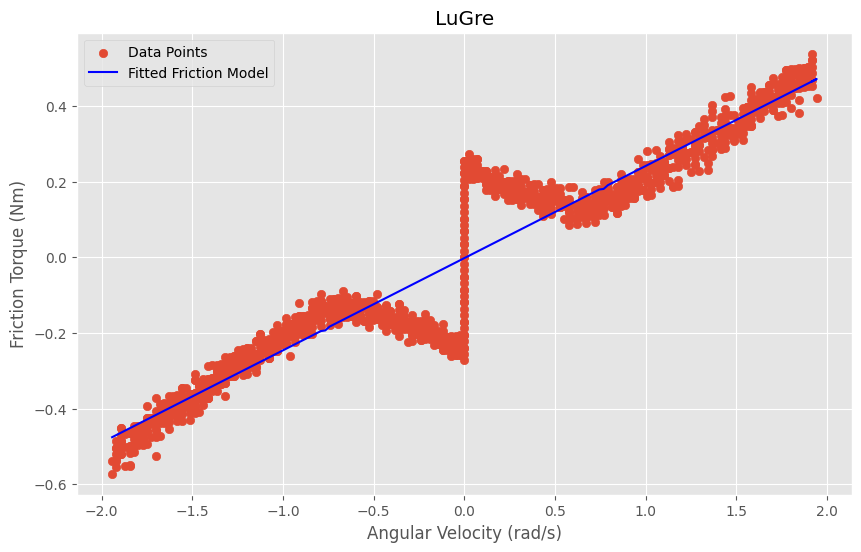

In [13]:
def lugre_model(omega, bristle_deflection, bristle_stiffness, damping_coefficient):
    def stribeck(x_dot):
        fc = dynamic_friction_torque
        fs = stiction_torque
        return fc + (fs - fc) * np.exp(-(x_dot / stribeck_velocity)**2)

    def bristle_deflection_dot(x_dot, bristle_deflection):
        return x_dot - (np.abs(x_dot) / stribeck(x_dot)) * bristle_deflection

    return bristle_stiffness * bristle_deflection + damping_coefficient * bristle_deflection_dot(omega, bristle_deflection) + viscous_friction_coefficient * omega

popt, pcov = curve_fit(lugre_model, angular_velocities, motor_torques)

plot_model(lugre_model, popt, "LuGre")

The LuGre model being one of the most accurate models as of today, we did not manage to make it work on our data due to an unknown factor.